In [100]:
# ============================================
# 0) Imports & setup
# ============================================
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib

plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")
pd.set_option("display.max_columns", None)

In [101]:
# ============================================
# 1) Load preprocessed artifacts
# - Clean (encoded) dataset
# - Clean + scaled dataset
# - Encoders & scaler
# ============================================

df = pd.read_csv("../data/german_credit_data_clean.csv")
df_scaled = pd.read_csv("../data/german_credit_data_clean_scaled.csv")

encoders = joblib.load("../models/label_encoders.pkl")
scaler    = joblib.load("../models/standard_scaler.pkl")

print(df.shape, df_scaled.shape)  # Both of them should be (1000, 9)
df.head(2)

(1000, 9) (1000, 9)


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,1,4,0,1169,6,5
1,22,0,2,1,0,1,5951,48,5


In [102]:
# ============================================
# 2) First clustering baseline (KMeans)
# We'll start simple with 3 clusters; we'll tune later with elbow/silhouette.
# ============================================
X = df_scaled[["Age", "Duration", "Credit amount", "Sex", "Job", "Housing",
               "Saving accounts", "Checking account", "Purpose"]].values

kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X)

df_clusters = df.copy()
df_clusters["cluster"] = labels

# quick view of cluster sizes
df_clusters["cluster"].value_counts().sort_index()


cluster
0    147
1    408
2    445
Name: count, dtype: int64

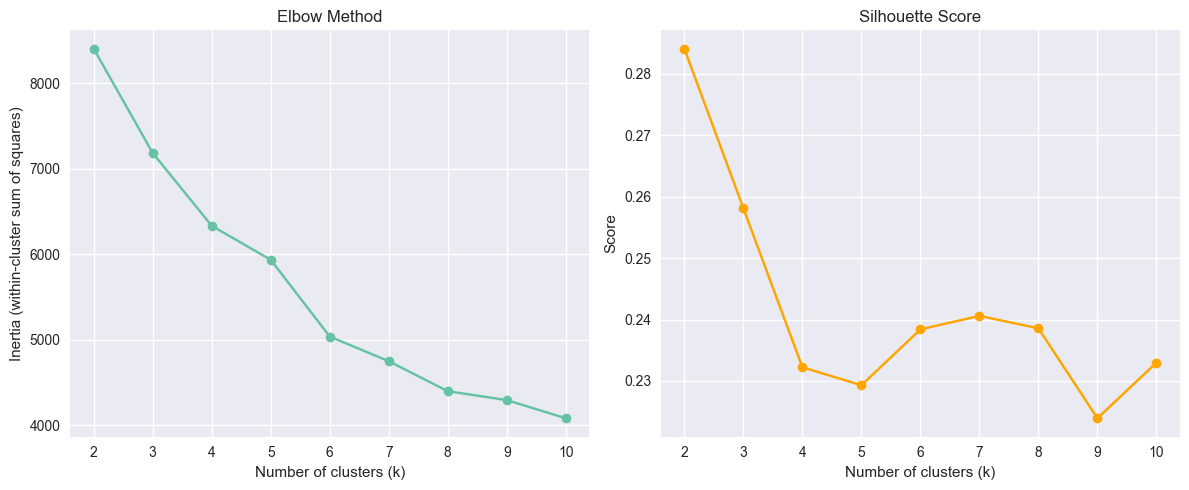

In [103]:
# ============================================
# 3) Optimize cluster count: Elbow & Silhouette
# ============================================

X = df_scaled[["Age", "Duration", "Credit amount", "Sex", "Job", "Housing",
               "Saving accounts", "Checking account", "Purpose"]].values

inertia = []        # # total error for each k
silhouette_scores = []  # silhouette score for each k

K = range(2, 11)  # test cluster numbers from 2 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X)
    
    inertia.append(kmeans.inertia_)  # total error
    silhouette_scores.append(silhouette_score(X, labels))  # quality

# --- Let's plot the graphs ---
plt.figure(figsize=(12,5))

# Elbow
plt.subplot(1,2,1)
plt.plot(K, inertia, marker="o")
plt.title("Elbow Method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster sum of squares)")

# Silhouette
plt.subplot(1,2,2)
plt.plot(K, silhouette_scores, marker="o", color="orange")
plt.title("Silhouette Score")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Score")

plt.tight_layout()
plt.show()


**Cluster Number Optimization (Elbow & Silhouette)**

Initially, I chose 3 clusters for KMeans, but I wanted to check whether this choice was correct. Therefore, I applied the **Elbow Method** and **Silhouette Score**.  

- In the Elbow chart, I observed a clear bend around **k=3 or k=4**.  
- In the Silhouette score, the highest value appeared at **k=2**, but this would have resulted in overly simplistic clusters. A more balanced and meaningful choice was clearly **k=3**.  

After this analysis, I confirmed that my initial choice of **3 clusters was indeed reasonable**.


**4) Model Persistence & Reproducibility**

I saved the final **K-Means model**, **encoders**, and **scaler**.  
This makes the experiment **reproducible** and allows me to easily score new records later (e.g., in a **Streamlit interface**).  
Keeping **artifacts versioned** also ensures that future results can be compared against this **baseline**.  

In [104]:
# ============================================
# 4) Persist model (save KMeans for later use)
# ============================================

# 1. Train final KMeans model with chosen k (e.g., 3 clusters)
final_k = 3
final_kmeans = KMeans(n_clusters=final_k, random_state=42, n_init="auto")
final_labels = final_kmeans.fit_predict(X)

# 2. Save the model to models/ folder
joblib.dump(final_kmeans, "../models/kmeans_model.pkl")
print("Model saved: ../models/kmeans_model.pkl")

# 3. Add final cluster labels to dataframe for analysis
df_clusters_final = df.copy()
df_clusters_final["cluster"] = final_labels

# Quick view of cluster sizes
print("\nCluster sizes:")
print(df_clusters_final["cluster"].value_counts().sort_index())


Model saved: ../models/kmeans_model.pkl

Cluster sizes:
cluster
0    147
1    408
2    445
Name: count, dtype: int64


In [105]:
# ============================================
# 5) Build analysis frame from the persisted model
#    - get labels with the FINAL KMeans
# ============================================

# Names of the 9 features fed to KMeans
feature_cols = [
    "Age", "Duration", "Credit amount",
    "Sex", "Job", "Housing", "Saving accounts",
    "Checking account", "Purpose"
]
num_cols = ["Age", "Duration", "Credit amount"]

# Modeling matrix
X = df_scaled[feature_cols].values

# Use the trained model
try:
    km = final_kmeans
except NameError:
    import joblib
    km = joblib.load("../models/kmeans_model.pkl")

labels = km.predict(X)

# Build analysis frame
df_clusters = df.copy()
df_clusters["cluster"] = labels

# quick check
print("Cluster sizes:\n", df_clusters["cluster"].value_counts().sort_index())


Cluster sizes:
 cluster
0    147
1    408
2    445
Name: count, dtype: int64


**6–7) Cluster Profiles & Naming (Business Interpretation)**

I summarized the clusters using **numerical averages** (age, duration, credit amount)  
and **categorical shares** (e.g., housing, purpose).  

Then, to make communication with **non-technical stakeholders** easier,  
I created simple, intuitive names (e.g., **“Higher-Amount Segment”**, **“Younger / Short-Duration”**).  

These are not prescriptive labels but **explanatory names**  
that facilitate **discussion** and **decision-making**.  


In [106]:
# ============================================
# 6) Cluster summaries (numeric + categorical)
#    - readable labels
#    - compact profile table
# ============================================

plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

os.makedirs("../data", exist_ok=True)
os.makedirs("../images/cluster_summaries", exist_ok=True)

# 6.1) Size + numeric summaries
cluster_sizes = (
    df_clusters["cluster"].value_counts().sort_index().rename("count")
)
num_summary = (
    df_clusters.groupby("cluster")[num_cols]
    .agg(["mean","median","std","min","max"])
    .round(2)
)

display(cluster_sizes)
display(num_summary)

cluster_sizes.to_csv("../data/cluster_sizes.csv")
num_summary.to_csv("../data/cluster_numeric_summary.csv")

# 6.2) Categoricals: human-readable labels
cat_cols = ["Sex","Job","Housing","Saving accounts","Checking account","Purpose"]

# extract the class names from the encoders dict
label_maps = {}
for c in cat_cols:
    if c in encoders:
        classes = encoders[c].classes_
        label_maps[c] = {i: classes[i] for i in range(len(classes))}
    else:
        label_maps[c] = None

# cross-tab + convert to percentages + rename columns with labels
cat_tables = {}
for col in cat_cols:
    ct = pd.crosstab(df_clusters["cluster"], df_clusters[col])
    if label_maps[col]:
        ct = ct.rename(columns=label_maps[col])
    ct_pct = (ct.div(ct.sum(axis=1), axis=0) * 100).round(2)
    cat_tables[col] = ct_pct
    ct_pct.to_csv(f"../data/cluster_cat_{col}_share.csv")
    print(f"\nCategorical share by cluster → {col}")
    display(ct_pct)


cluster
0    147
1    408
2    445
Name: count, dtype: int64

Age                       Duration                        \
          mean median    std min max     mean median    std min max   
cluster                                                               
0        37.50   35.0  11.69  19  67    20.45   18.0  11.90   6  60   
1        33.49   31.0  10.66  19  67    19.75   18.0  11.42   4  72   
2        36.79   35.0  11.63  20  75    22.11   20.0  12.58   4  60   

        Credit amount                               
                 mean  median      std  min    max  
cluster                                             
0             2845.40  2030.0  2464.39  368  14179  
1             2802.85  2098.0  2386.83  338  18424  
2             3841.39  2760.0  3181.34  250  15945


Categorical share by cluster → Sex


Sex,female,male
cluster,,
0,31.97,68.03
1,36.03,63.97
2,26.07,73.93



Categorical share by cluster → Job


Job,0,1,2,3
cluster,,,,
0,1.36,19.73,69.39,9.52
1,1.47,20.59,65.69,12.25
2,3.15,19.55,58.43,18.88



Categorical share by cluster → Housing


Housing,free,own,rent
cluster,,,
0,7.48,76.19,16.33
1,8.82,73.04,18.14
2,13.71,68.09,18.20



Categorical share by cluster → Saving accounts


Saving accounts,little,moderate,quite rich,rich,unknown
cluster,,,,,
0,0.00,0.00,19.05,16.33,64.63
1,86.52,10.78,2.70,0.00,0.00
2,56.18,13.26,5.39,5.39,19.78



Categorical share by cluster → Checking account


Checking account,little,moderate,rich,unknown
cluster,,,,
0,12.93,23.13,6.80,57.14
1,32.35,27.21,7.11,33.33
2,27.64,27.87,5.39,39.10



Categorical share by cluster → Purpose


Purpose,business,car,domestic appliances,education,furniture/equipment,radio/TV,repairs,vacation/others
cluster,,,,,,,,
0,0.0,0.00,2.04,13.61,27.21,52.38,3.40,1.36
1,0.0,0.00,0.00,9.07,34.56,49.75,4.17,2.45
2,21.8,75.73,2.02,0.45,0.00,0.00,0.00,0.00


In [107]:
# ============================================
# 7) Compact profile + simple names
# - add top-k categorical highlights
# - suggest a name (heuristic)
# ============================================

from pathlib import Path

def top_k_categories_by_cluster(dfc, col, k=3):
    ct = pd.crosstab(dfc["cluster"], dfc[col])
    # rename columns with labels (make plots/outputs readable)
    if label_maps[col]:
        ct = ct.rename(columns=label_maps[col])
    share = (ct.div(ct.sum(axis=1), axis=0) * 100)
    tops = {}
    for cl in share.index:
        s = share.loc[cl].sort_values(ascending=False).head(k)
        tops[cl] = [f"{idx} ({val:.1f}%)" for idx, val in s.items()]
    return tops

tops_housing  = top_k_categories_by_cluster(df_clusters, "Housing", k=2)
tops_purpose  = top_k_categories_by_cluster(df_clusters, "Purpose", k=3)
tops_checking = top_k_categories_by_cluster(df_clusters, "Checking account", k=2)

profiles = []
for cl, g in df_clusters.groupby("cluster"):
    row = {
        "cluster": cl,
        "size": len(g),
        "mean_age": g["Age"].mean().round(1),
        "mean_duration": g["Duration"].mean().round(1),
        "mean_credit_amount": g["Credit amount"].mean().round(0),
        "top_housing": "; ".join(tops_housing.get(cl, [])),
        "top_purpose": "; ".join(tops_purpose.get(cl, [])),
        "top_checking": "; ".join(tops_checking.get(cl, [])),
    }
    profiles.append(row)

cluster_profiles = pd.DataFrame(profiles).sort_values("cluster").reset_index(drop=True)

# Simple naming rule
def name_cluster(row):
    amt = row["mean_credit_amount"]
    dur = row["mean_duration"]
    age = row["mean_age"]
    if amt > cluster_profiles["mean_credit_amount"].median() and dur > cluster_profiles["mean_duration"].median():
        return "High-Amount / Long-Duration"
    if amt > cluster_profiles["mean_credit_amount"].median():
        return "Higher-Amount Segment"
    if dur < cluster_profiles["mean_duration"].median() and age < cluster_profiles["mean_age"].median():
        return "Younger / Short-Duration"
    return "Balanced Segment"

cluster_profiles["suggested_name"] = cluster_profiles.apply(name_cluster, axis=1)

display(cluster_profiles)

cluster_profiles.to_csv("../data/cluster_profiles.csv", index=False)
print("Saved: ../data/cluster_profiles.csv")


,cluster,size,mean_age,mean_duration,mean_credit_amount,top_housing,top_purpose,top_checking,suggested_name
0,0,147,37.5,20.4,2845.0,own (76.2%); rent (16.3%),radio/TV (52.4%); furniture/equipment (27.2%);...,unknown (57.1%); moderate (23.1%),Balanced Segment
1,1,408,33.5,19.8,2803.0,own (73.0%); rent (18.1%),radio/TV (49.8%); furniture/equipment (34.6%);...,unknown (33.3%); little (32.4%),Younger / Short-Duration
2,2,445,36.8,22.1,3841.0,own (68.1%); rent (18.2%),car (75.7%); business (21.8%); domestic applia...,unknown (39.1%); moderate (27.9%),High-Amount / Long-Duration


Saved: ../data/cluster_profiles.csv


**8) Category Shares per Cluster (Basic Visual Insights)**

I used **stacked bar charts** to show the distribution of categorical variables across clusters.  

By adding **percentage labels** and **readable legends**,  
I clarified which categories **dominate in which clusters**.  

Compared to **table summaries**,  
this allows insights to be generated **much more quickly**.

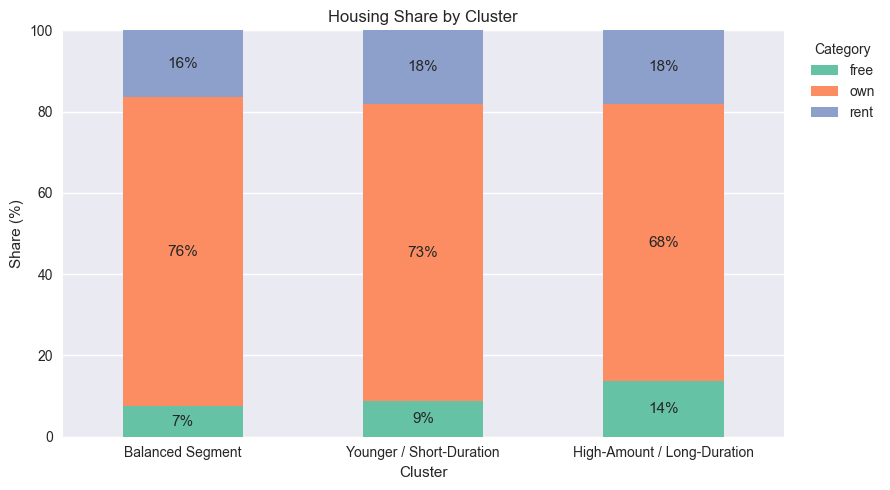

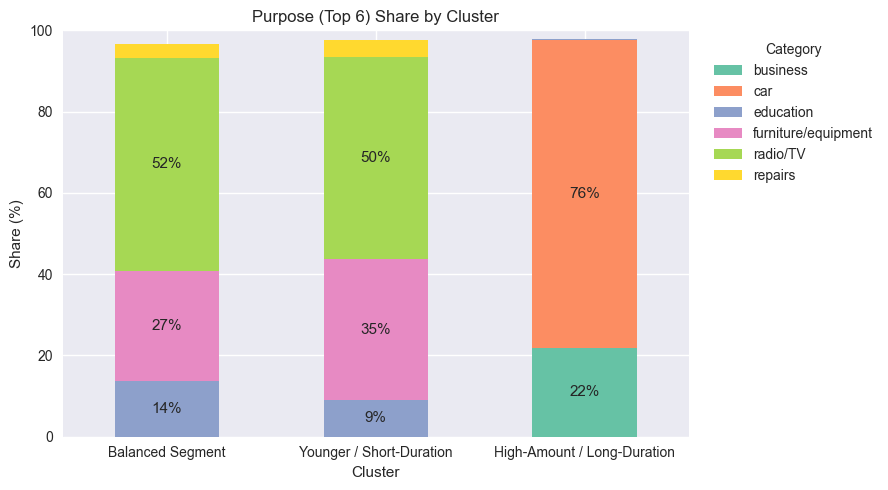

In [108]:
# ============================================
# 8) Visuals (with readable legends & % labels)
# ============================================

# Map for cluster names (axis labels)
cluster_name_map = cluster_profiles.set_index("cluster")["suggested_name"].to_dict()

def stacked_share_plot(share_table, title, outfile, label_threshold=5):
    """
    share_table: rows=clusters, columns=categories, values=percent (0-100)
    label_threshold: yüzde etiketi yazmak için alt eşik (örn. 5 = %5 altını yazma)
    """
    ax = share_table.plot(kind="bar", stacked=True, figsize=(9,5))

    # Label the x-axis with cluster names
    ax.set_xticklabels([cluster_name_map.get(i, f"Cluster {i}") for i in share_table.index], rotation=0)
    ax.set_ylim(0, 100)
    plt.title(title)
    plt.xlabel("Cluster")
    plt.ylabel("Share (%)")
    plt.legend(title="Category", bbox_to_anchor=(1.02, 1), loc="upper left")

    # For each bar (cluster), write percentage labels at the center of segments
    for i, (_, row) in enumerate(share_table.iterrows()):
        cum = 0.0
        for col in share_table.columns:
            val = float(row[col])
            if val >= label_threshold:
                ax.text(
                    i,                 # x position (bar index)
                    cum + val/2.0,     # segment midpoint (y)
                    f"{val:.0f}%",     # text
                    ha="center", va="center", fontsize=11
                )
            cum += val

    plt.tight_layout()
    plt.savefig(outfile, dpi=150)
    plt.show()

# Example: plots for Housing and Purpose
if "Housing" in cat_tables:
    stacked_share_plot(
        cat_tables["Housing"],
        "Housing Share by Cluster",
        "../images/cluster_summaries/housing_share_by_cluster.png"
    )

if "Purpose" in cat_tables:
    # For readability, use the top 6 most frequent purposes (may not sum to 100%; that’s expected)
    top6 = df_clusters["Purpose"].map(label_maps["Purpose"]).value_counts().head(6).index
    purpose_share = cat_tables["Purpose"][cat_tables["Purpose"].columns.intersection(top6)]
    stacked_share_plot(
        purpose_share,
        "Purpose (Top 6) Share by Cluster",
        "../images/cluster_summaries/purpose_share_by_cluster.png"
    )


**9) Converting Centers Back to Original Scale (Numerical Only)**

To simplify interpretation, I transformed the **K-Means cluster centers**  
back into their **original units**:  

- Age → **years**  
- Duration → **months**  
- Credit amount → **currency**  

This makes it easier to check whether the segments align with **realistic thresholds**  
(e.g., **“average duration ~22 months”**).

In [109]:
# ============================================
# Debug: explain a single assignment (distances & confidence)
# Requires: km, encoders, scaler, feature_cols, num_cols
# (optional) cluster_name_map for pretty names
# ============================================
import numpy as np

def _encode_scale_one(row_dict):
    vals = []
    for c in feature_cols:
        v = row_dict[c]
        if c in encoders:  # categorical -> label encode
            le = encoders[c]
            if v not in le.classes_:
                # fall back to 'unknown' if exists
                if "unknown" in le.classes_:
                    v = "unknown"
                else:
                    raise ValueError(f"Unknown category for {c}: {v}")
            v = le.transform([v])[0]
        vals.append(v)
    x = np.array(vals, dtype=float).reshape(1, -1)
    # scale only numeric columns
    num_idx = [feature_cols.index(c) for c in num_cols]
    x[:, num_idx] = scaler.transform(x[:, num_idx])
    return x

def explain_assignment(row_dict, cluster_name_map=None):
    x = _encode_scale_one(row_dict)
    dists = np.linalg.norm(km.cluster_centers_ - x, axis=1)  # L2 to each centroid
    order = np.argsort(dists)
    best, second = order[0], order[1]
    confidence = float(dists[second] / dists[best])  # ↑ bigger = more confident
    name = cluster_name_map.get(best, f"Cluster {best}") if cluster_name_map else f"Cluster {best}"
    print("Distances:", {int(i): float(f"{d:.3f}") for i, d in enumerate(dists)})
    print(f"→ Pred: {best} {name} | confidence≈{confidence:.2f}")
    return best, name, dists, confidence

sample = {
    "Age": 36, "Duration": 24, "Credit amount": 3000,
    "Sex": "female", "Job": 2, "Housing": "own",
    "Saving accounts": "moderate", "Checking account": "moderate",
    "Purpose": "furniture/equipment"
}
explain_assignment(sample, cluster_name_map)  # cluster_name_map varsa daha okunur çıktı


Distances: {0: 2.829, 1: 1.342, 2: 3.345}
→ Pred: 1 Younger / Short-Duration | confidence≈2.11


C:\Users\emrekarata\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(1,
 'Younger / Short-Duration',
 array([2.82897856, 1.34186607, 3.34522555]),
 2.1082421071997017)

In [110]:
# ============================================
# 9) KMeans centers back to ORIGINAL scale (numeric only)
# ============================================

from joblib import load

try:
    scaler = load("../models/standard_scaler.pkl")
    centers_mat = km.cluster_centers_  # centers of the final model
    centers = pd.DataFrame(centers_mat, columns=feature_cols)

    centers_num_scaled = centers[num_cols].values
    centers_num_orig   = scaler.inverse_transform(centers_num_scaled)
    centers_num_df     = pd.DataFrame(
        centers_num_orig, columns=[f"{c} (orig)" for c in num_cols]
    )
    centers_view = centers_num_df.copy()
    centers_view.insert(0, "cluster", range(len(centers_view)))

    display(centers_view.round(2))
    centers_view.round(2).to_csv("../data/cluster_centers_numeric_original_scale.csv", index=False)
    print("Saved: ../data/cluster_centers_numeric_original_scale.csv")
except Exception as e:
    print("Centroid inverse-transform skipped:", e)

,cluster,Age (orig),Duration (orig),Credit amount (orig)
0,0,37.50,20.45,2845.40
1,1,33.49,19.75,2802.85
2,2,36.79,22.11,3841.39


Saved: ../data/cluster_centers_numeric_original_scale.csv


In [111]:
# notebooks/03_Clustering.ipynb içinden (en sonda bir hücre)
import json
from pathlib import Path

Path("../models").mkdir(exist_ok=True, parents=True)

# 1) Özellik sırası
feature_cols = [
    "Age", "Duration", "Credit amount",
    "Sex", "Job", "Housing", "Saving accounts",
    "Checking account", "Purpose"
]
with open("../models/feature_cols.json", "w") as f:
    json.dump(feature_cols, f)

# 2) Küme isimleri (cluster_profiles'tan)
cluster_name_map = cluster_profiles.set_index("cluster")["suggested_name"].to_dict()
with open("../models/segment_names.json", "w") as f:
    json.dump(cluster_name_map, f)

# 3) (Opsiyonel) Kategorik sınıf isimleri: yalnızca okunur görselleştirme için lazım
label_maps = {}
for c in ["Sex","Job","Housing","Saving accounts","Checking account","Purpose"]:
    if c in encoders:
        classes = encoders[c].classes_.tolist()
        label_maps[c] = {int(i): classes[i] for i in range(len(classes))}
with open("../models/label_maps.json", "w") as f:
    json.dump(label_maps, f)

print("Saved meta:")
print(" - models/feature_cols.json")
print(" - models/segment_names.json")
print(" - models/label_maps.json")


Saved meta:
 - models/feature_cols.json
 - models/segment_names.json
 - models/label_maps.json
